In [1]:
import sys
sys.path.append('../../../') # Add the root directory to sys.path

In [2]:
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from models.starnet import StarNet
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

In [3]:
data_dir = '../../../data/Gaia DR3/train.parquet'

In [4]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,2264606414026248192,5212.299316,4.4992,-1.2461,G,LM,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,17552.250000,3.4490,0.4213,B,M,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,5810.870605,3.9213,-0.5051,F,LM,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,14714.115234,3.8890,-0.2898,B,LM,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,7999.921387,3.1459,-2.2106,B,M,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [6]:
df = data.drop(columns = ['Cat', 'spectraltype_esphs'])
df.head()

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,flux
0,2264606414026248192,5212.299316,4.4992,-1.2461,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,17552.250000,3.4490,0.4213,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,5810.870605,3.9213,-0.5051,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,14714.115234,3.8890,-0.2898,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,7999.921387,3.1459,-2.2106,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14101 entries, 0 to 14100
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   source_id     14101 non-null  int64  
 1   teff_gspphot  14101 non-null  float32
 2   logg_gspphot  14101 non-null  float32
 3   mh_gspphot    14101 non-null  float32
 4   flux          14101 non-null  object 
dtypes: float32(3), int64(1), object(1)
memory usage: 385.7+ KB


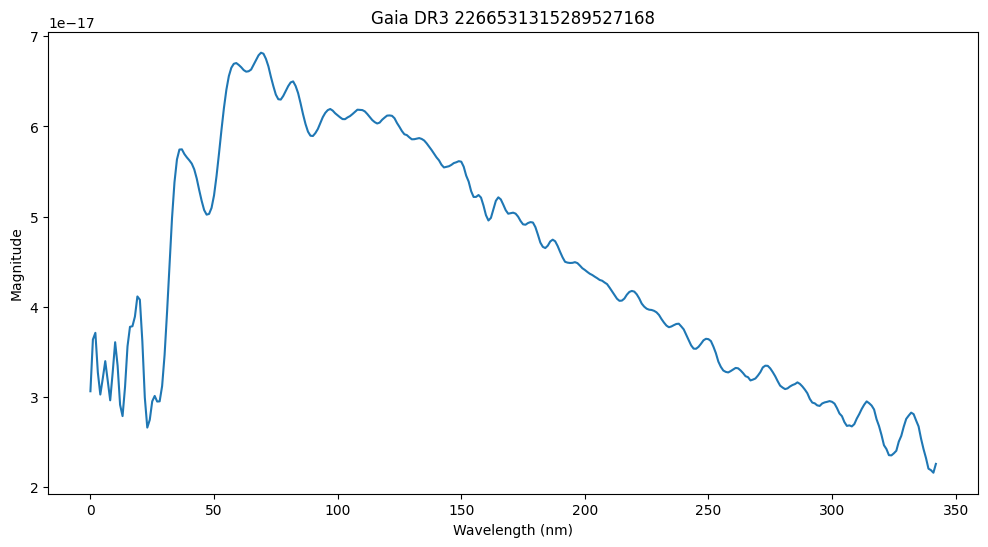

In [19]:
# rerun this cell to see random different spectra
sample_ms = df['flux'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

plt.figure(figsize=(12, 6))

plt.plot(flux_ms)
plt.title(f"Gaia DR3 {object_id_ms}")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.show()

In [20]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)

Number of total spectral samples: 14101
Number of bins in each spectra: 343


In [24]:
X = np.vstack(df['flux'])
y = np.vstack(df[['teff_gspphot','logg_gspphot','mh_gspphot']])

# L2 normalization
X = torch.from_numpy(X/np.linalg.norm(X,keepdims=True)).float()

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
def fit_model(model, x_train, y_train, x_val, y_val, prt_steps = 1, verbose=True):
    
    # initialize weights
    model.apply(init_weights)

    # hyperparameters
    epochs = 200
    learning_rate = 1e-4
    batch_size = 64
    device = 'cuda'
    
    # model components
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # move everything to gpu
    model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)

    # metrics
    training_losses, validation_losses = [], []
    accuracy = []
    
    # lr cycling
    max_lr = 1e-2
    steps_per_epoch = len(x_train) // batch_size
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs)

    batch_start = torch.arange(0, len(x_train), batch_size)

    for epoch in tqdm(range(epochs), desc='Epochs', dynamic_ncols=True):
        
        model.train()
        running_loss = 0

        for start in batch_start:

            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            output = model(x_batch.unsqueeze(1))
            loss = criterion(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * x_batch.size(0)

        train_loss = running_loss / len(x_train)
        training_losses.append(train_loss)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}', end='\r')


        model.eval()
        preds, labels = [], []

        with torch.no_grad():
            
            output = model(x_val.unsqueeze(1))
            loss = criterion(output, y_val)

            probs = torch.sigmoid(output)
            pred = torch.round(probs).cpu().numpy().astype(float)  # pred: [batch_size]
            
            preds.extend(pred)
            labels.extend(y_val.cpu().numpy())
            
            val_loss = loss.item()
        
        epoch_acc = accuracy_score(labels, preds)

        validation_losses.append(val_loss)
        accuracy.append(epoch_acc)
        
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {epoch_acc:.4f}', end='\r')    
            
    return training_losses, validation_losses, accuracy

In [ ]:
kfold = StratifiedKFold(n_splits=5)

training_losses, validation_losses, accuracy_scores = [], [], []

params = {
    'num_fluxes':spectrum_width, 
    'filter_length':3, 
    'pool_length':4,
    'num_filters':[4,16],
    'num_hidden':[256,128],
    'num_labels':y.size(1)
}

model = StarNet(**params)
print(model)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    
    print(f"\nFitting fold {fold+1}")

    tr_loss, val_loss, acc = fit_model(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx])
    training_losses.append(tr_loss)
    validation_losses.append(val_loss)
    accuracy_scores.append(acc)

training_losses = np.mean(training_losses, axis=0)
validation_losses = np.mean(validation_losses, axis=0)
accuracy_scores = np.mean(accuracy_scores, axis=0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))
    
ax1.plot(accuracy_scores, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(training_losses, label='Training Loss')
ax2.plot(validation_losses, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

plt.tight_layout()
plt.show()